In [1]:
from keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import datetime as dt
import time
import glob
from IPython import display
import tensorflow as tf

import datetime as dt

Using TensorFlow backend.


In [2]:
#Load model bellow

In [3]:
def plot_autoencoder_outputs(encoder, n, dims):
    #decoded_imgs = enconder.predict(x_test)
    x_test_encoded = vae.predict(x_test, batch_size = batch_size)
    # number of example digits to show
    n = 5
    plt.figure(figsize=(20, 9))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_test_encoded[i].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

In [4]:
def load_JESTER(path):
    """
    Imports the JESTER Dataset (12,2,100,176)
    """
    xs_train, ys_train, xs_test, ys_test = [], [], [], []

    classList=['Swiping_Left', 'Swiping_Right', 'Swiping_Up', 'Swiping_Down']
    #classList=['Swiping_Left', 'Swiping_Right', 'Swiping_Up']    
    for class_index in classList:
#         for (root, dirs, f) in os.walk('{0}/n_Train/{1}'.format(path, str(class_index))):
#             cnt=0
#             print('Loading Train set')
#             for file in f:
#                 cnt += 1
#                 if (cnt == 1001):
#                     #print('Percent : {}%'.format(round((cnt / len(f)) * 100, 2)))
#                     break
                
#                 X=np.load('{0}/n_Train/{1}/{2}'.format(path, str(class_index), file))
#                 xs_train.append(X)
#                 ys_train.append(class_index)

        for (root, dirs, f) in os.walk('{0}/n_Test/{1}'.format(path, str(class_index))):
            cnt=0
            print('Loading Test set')
            for file in f:
                cnt += 1
                if (cnt == 105):
                    print('Percent : {}%'.format(round((cnt / len(f)) * 100, 2)))
                    break
                        
                X = np.load('{0}/n_Test/{1}/{2}'.format(path, str(class_index), file))
                xs_test.append(X)
                ys_test.append(class_index)

  #  Xtr = np.array(xs_train)
    #Ytr = np.array(ys_train)
    Xte = np.array(xs_test)
    Yte = np.array(ys_test)
    
    return Xte, Yte

In [5]:
dataset_class_path = 'M:/LowPowerActionRecognition/CNN/JESTER/datasets/n_JESTER'
x_test_1, y_test = load_JESTER(dataset_class_path)

# As a sanity check, we print out the size of the training and test data.

print('Test data shape: ', x_test_1.shape)
print('Test labels shape: ', y_test.shape)

Loading Test set
Percent : 21.26%
Loading Test set
Percent : 21.6%
Loading Test set
Percent : 20.67%
Loading Test set
Percent : 20.19%
Test data shape:  (416, 12, 2, 100, 176)
Test labels shape:  (416,)


In [6]:
print(type(x_test_1[1][1][1][1][1]))

<class 'numpy.int32'>


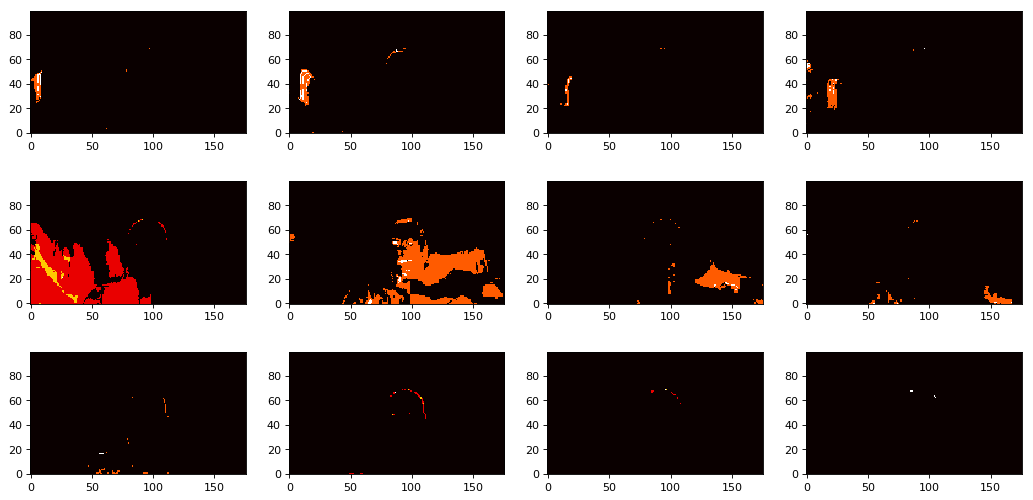

In [7]:
#Visualisation in 12 chunks
#x_test_vis = x_test.astype('float32')
x_test_vis = x_test_1.reshape(416,12,2,100,176)
#x_test_vis = x_test_vis.reshape(4992,2,104,176)

A= x_test_vis[2]

fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
for cnt,i in enumerate(range(12)):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(A[i][0], cmap='hot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format(cnt*2))
    plt.imshow(A[i][1], cmap='hot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format((cnt*2)+1))

In [8]:
x_test_2 = x_test_1.reshape(4992, 100, 176, 2)

x_test_3 = np.zeros((4992, 104, 176, 2))

for i in range (0, x_test_2.shape[0]):
    #print(i)
#     x_train_3[i] = np.pad(x_train_2[i], ((2, 2), (0, 0), (0, 0)), 'edge')
#     if (i < x_test_2.shape[0]):
        x_test_3[i] = np.pad(x_test_2[i], ((2, 2), (0, 0), (0, 0)), 'edge')

In [9]:
x_test = (x_test_3.astype('float16'))


In [10]:
x_test[:] = [x / 5 for x in x_test]

# Load the models to be ready for testing

In [11]:
#LOAD THE MODELS HERE

encoder = load_model('encoder_Chingis_4.h5', custom_objects={'batch_size': 32,'latent_dim': 30,'epsilon_std':0.001})
decoder = load_model('decoder_Chingis_4.h5', custom_objects={'batch_size': 32,'latent_dim': 30,'epsilon_std':0.001})

#vae = load_model('CVAE_Chingis_4.h5', custom_objects={'batch_size': 32,'latent_dim': 30,'epsilon_std':0.001})

lrcn = load_model('lrcn-images.013-0.340.hdf5')

M:\Anaconda\envs\cs231n\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
M:\Anaconda\envs\cs231n\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [12]:
# Take z value out from the encoder (ignore z_mean and z_var as first 2 values)
start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

_,_,z2 = encoder.predict(x_test,batch_size = 32)

end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))


Start learning at 2019-03-25 21:32:50.823918
Stop learning 2019-03-25 21:33:05.320354
Elapsed learning 0:00:14.496436


In [53]:
# Test to see the output
#print(z2)

In [14]:
#Feed the z value to the decoder AND the output is the DATA

start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

data_output = decoder.predict(z2) 

end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

Start learning at 2019-03-25 21:33:05.339303
Stop learning 2019-03-25 21:33:19.393525
Elapsed learning 0:00:14.054222


In [15]:
# Data in following shape: (4992, 104, 176, 2)
# Next step is to change it back into (416, 12, 2, 100, 176)

print(data_output.shape)

(4992, 104, 176, 2)


In [16]:
#print(y_test[400])

Swiping_Down


-----------------------------------------------------
Gesture is:  Swiping_Left 11
-----------------------------------------------------


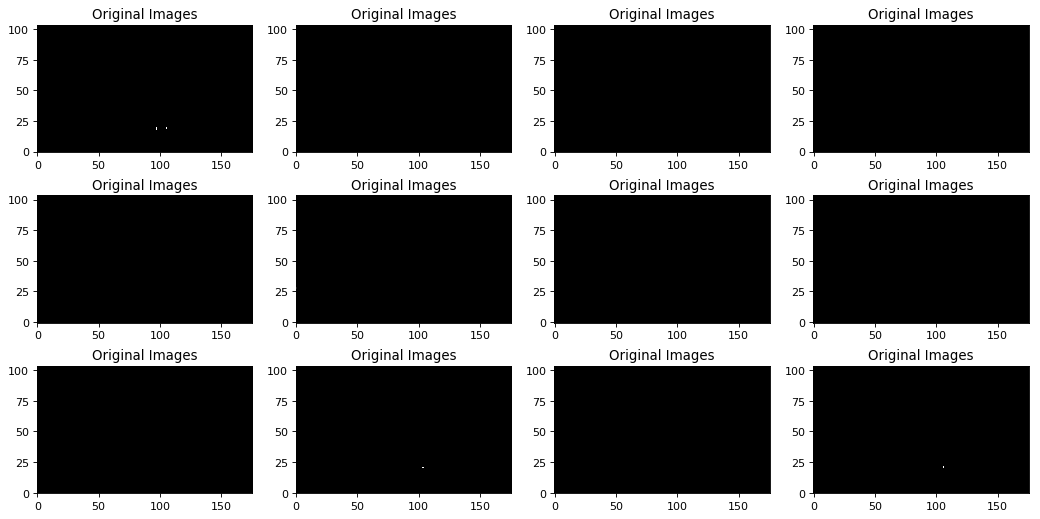

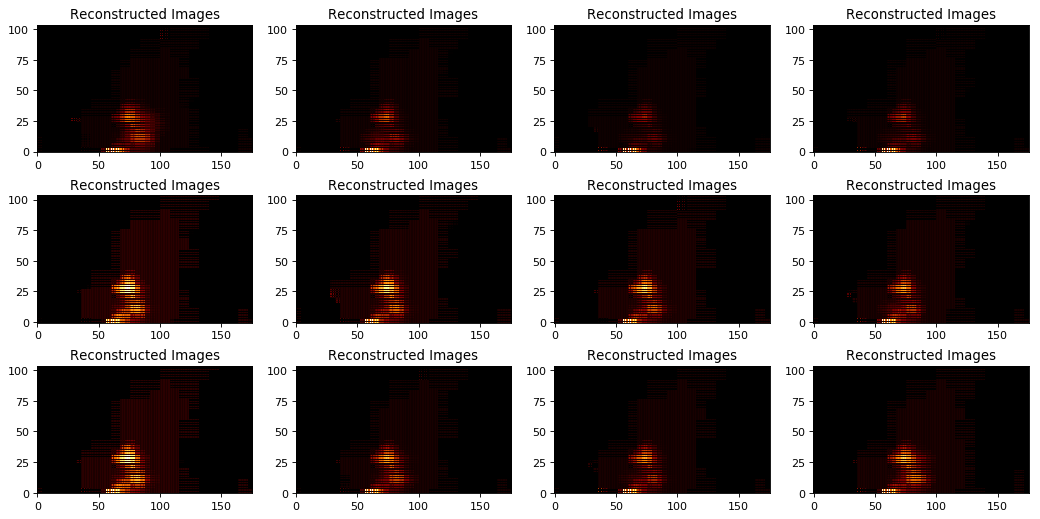

In [50]:
## Visualisation check

file_no = 11

print("-----------------------------------------------------")
print("Gesture is: ",y_test[file_no], file_no)
print("-----------------------------------------------------")

#Visualisation in 12 chunks
x_test_4 = (x_test.astype('float32'))

A0= x_test_4.reshape(416,12,2,104,176)

A = A0[file_no]
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
for cnt,i in enumerate(range(12)):
    ax = plt.subplot(3,4, i + 1)
    ax.set_title('Original Images')
    plt.imshow(A[i][0], cmap='afmhot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format(cnt*2))
    plt.imshow(A[i][1], cmap='afmhot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format((cnt*2)+1))

    
#Visualisation in 12 chunks
A1= data_output.reshape(416,12,2,104,176)
A = A1[file_no]
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
for cnt,i in enumerate(range(12)):
    ax = plt.subplot(3, 4, i + 1)
    ax.set_title('Reconstructed Images')
    plt.imshow(A[i][0], cmap='afmhot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format(cnt*2))
    plt.imshow(A[i][1], cmap='afmhot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format((cnt*2)+1)

In [18]:
#Check to see the values for the decoded data
#print(A1)
#print(type(A1))

In [19]:
# Use SLICE to remove the empty 4 zeroes (104->100)


start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))


#print(A1[:,:,:,1:-3].shape) # check this later! 
A2 = A1[:,:,:,1:-3]
#print(A2)

end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

Start learning at 2019-03-25 21:33:21.986294
Stop learning 2019-03-25 21:33:21.986294
Elapsed learning 0:00:00


In [51]:
# Input the data here to the lrcn
start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

A_in = A2[file_no].reshape(1,12,100,176,2)
acc = lrcn.predict(A_in)

end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

# Correct accuracy here!
print("-----------------------------------------------------")
print("Gesture is: ",y_test[file_no])
print("-----------------------------------------------------")
print("Down | Left | Right | Up")

print(acc)
print("-----------------------------------------------------")
print("Accuracy chosen :",np.amax(acc))

Start learning at 2019-03-25 21:45:24.797988
Stop learning 2019-03-25 21:45:24.941113
Elapsed learning 0:00:00.143125
-----------------------------------------------------
Gesture is:  Swiping_Left
-----------------------------------------------------
Down | Left | Right | Up
[[0.23545557 0.29167718 0.20209903 0.2707682 ]]
-----------------------------------------------------
Accuracy chosen : 0.29167718


In [52]:
# # Correct accuracy here!
# print("-----------------------------------------------------")
# print("Gesture is: ",y_test[file_no])
# print("-----------------------------------------------------")
# print("Down | Left | Right | Up")

# print(acc)

In [33]:
A3 = A2.reshape(416,12,100,176,2)

print(A3.shape)

score = lrcn.evaluate(A3, y_test, verbose=1, batch_size=32,steps=None)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

(416, 12, 100, 176, 2)


ValueError: Error when checking target: expected dense_1 to have shape (4,) but got array with shape (1,)